<a href="https://colab.research.google.com/github/VMBoehm/NormalizingFlows/blob/master/RealNVP_on_fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fitting a RealNVP on Fashion-MNIST**




In [46]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     / 11.0MB 874kB/s


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
import tensorflow_datasets as dts
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [49]:
import os

from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

PROJ = "My Drive/NormalizingFlow" 
PROJECT_PATH = os.path.join(ROOT, PROJ)
print(PROJECT_PATH)
if not os.path.isdir(PROJECT_PATH):
  os.makedirs(PROJECT_PATH)

module_dir= os.path.join(PROJECT_PATH, 'module/')


Mounted at /content/gdrive
/content/gdrive/My Drive/NormalizingFlow


In [0]:
nvp_func_path    = os.path.join(module_dir, 'nvp1/')
if not os.path.isdir(nvp_func_path):
  os.makedirs(nvp_func_path)
  
plot_path        = os.path.join(PROJECT_PATH, '/plots')

if not os.path.isdir(plot_path):
  os.makedirs(plot_path)

In [0]:
mnist = tf.keras.datasets.fashion_mnist
#mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).reshape((-1,28*28))
x_test  = (x_test/255.).reshape((-1,28*28))

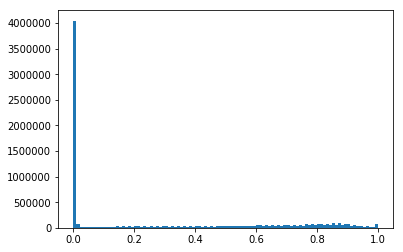

In [52]:
_= hist(x_test.flatten(),bins=100)

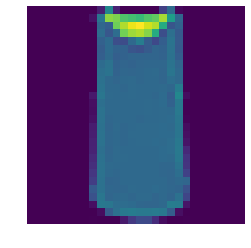

In [53]:
imshow(x_train[2].reshape((28,28)))
axis('off')
show()

define different data transforms

In [0]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA

class data_trafo():
  
  def __init__(self, types, params):
    
    self.types = types
    self.params= params
    
  def __call__(self,x):
    
    if 'smooth' in self.types:
      for ii in range(len(x)):
        # overwrites, but that's ok, because we dont need the inverse
        x[ii]=gaussian_filter(x[ii].reshape((-1,28,28)), sigma=self.params['sigma']).flatten()           
    
    if 'mask' in self.types:
      try:
         x=x[:,self.mask]
      except:
        x, mask   = self.mask_data(x)
        self.mask = mask
          
    if 'shift_rescale' in self.types:
      x-=0.5
      x*=10
  
    if 'pca' in self.types:
      try:
        self.dec
      except:
        pca      = PCA(n_components=self.params['n_comp'])
        self.dec = pca.fit(x)
      x        = self.dec.transform(x)
      
      
    if 'logit_transform' in self.types:
      x, maximum = self.rescale(x,self.params['alpha'])
      try:
        self.max
      except:
        self.max = maximum
    
  
    if 'box_cox' in self.types:
      x, mean, mini = self.box_cox(x,self.params['lambda'])
      try:
        self.mini
      except:
        self.mini=mini
      try:
        self.mean
      except:
        self.mean=mean
      
    return x
  
  def inverse(self,y):
    
    if 'box_cox' in self.types:
      y = self.inverse_box_cox(y,self.mean, self.mini, self.params['lambda'])
    
    if 'logit_transform' in self.types:
      y = self.inverse_rescale(y,self.params['alpha'],self.max)
    
    if 'pca' in self.types:
      y = self.dec.inverse_transform(y)
      
    if 'shift_rescale' in self.types:
      y/=10
      y+=0.5   
    
    if 'mask' in self.types:
      y = self.inverse_mask(y)
           
    return y
  
  
  def mask_data(self,x):
    st_dev = x.std(axis=0)
    mask   = np.where(st_dev>5e-2)[0]
    y      = x[:,mask]
    return y, mask
  
  def inverse_mask(self,y):
    x = np.zeros((len(y),28*28))
    x[:,self.mask] = y
    return x
  
  
  def logit(self,x):
    return log(x/(1.-x))
  
  def inverse_logit(self,y):
    return exp(y)/(exp(y)+1)
    
    
  def rescale(self,x,alpha):
    maximum = amax(x)*1.1
    return self.logit((alpha+(1.-alpha)*(x/maximum))), maximum
  
  def inverse_rescale(self,y,alpha,maximum):
    return (((self.inverse_logit(y)-alpha)/(1.-alpha)))*maximum
  
  
  def box_cox(self,x,l):
    minimum = np.amin(x)
    x = x-minimum*1.1
    x = (x**l-1.)/l
    mean = np.expand_dims(x.mean(),0)
    x-=mean
    return x, mean, minimum
  
  def inverse_box_cox(self,y,mean, minimum,l):
    y+=mean
    y = y*l+1.
    y = y**(1/l)
    y+=minimum*1.1
    return y
  

In [0]:
dt           = data_trafo(['logit_transform','mask'],{'sigma':1., 'lambda':1.4, 'n_comp':400, 'alpha':0.01})
x_train_prep = dt(x_train)

In [0]:
x_test_prep = dt(x_test)

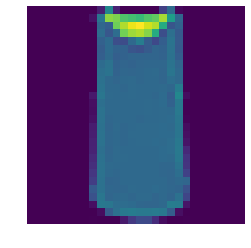

In [57]:
imshow(x_train[2].reshape((28,28)))
axis('off')
show()

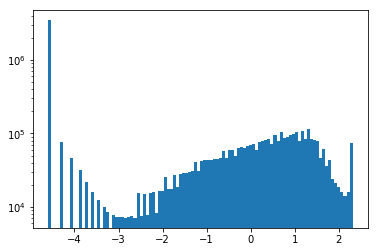

In [58]:
_= hist(x_test_prep.flatten(),bins=100, log=True)

In [59]:
data_dim    = x_train_prep.shape[-1]
print(data_dim)
batch_size  = 32
nvp_depth   = 6

736


getting checkerboard permutations

In [60]:
#get checkerboard
a = np.arange(0,data_dim+1,2)
b = np.arange(1,data_dim-1,2)

alternating_permutation = np.append(a,b)
print(alternating_permutation.shape)

#permute first and second half
a = np.arange(0,data_dim//2)
b = np.arange(data_dim//2,data_dim)
swapping_permutation = np.append(b,a)
print(swapping_permutation.shape)

np.random.seed(10101)

random_permutations = [np.random.permutation(np.arange(data_dim)) for ii in range(30)]

permutations = []
#permutations.append(alternating_permutation)
for ii in range(len(random_permutations)):
  permutations.append(swapping_permutation)
  permutations.append(random_permutations[ii])

(736,)
(736,)


In [61]:
tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.001,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)


def get_prior():
    return tfd.MultivariateNormalDiag(tf.zeros([data_dim]), scale_identity_multiplier=1.0, name ='prior')


x_tr              = tf.placeholder(shape=[batch_size,data_dim], dtype=tf.float32)


### ----------- NVP ----------- ###

def init_once(x, name):
  return tf.get_variable(name, initializer=x, trainable=False)


nvp_size      = [[512, 512] for ii in range(nvp_depth)]


def get_nvp():
  
  base_dis = get_prior()
  
  chain    = []
  
  perms         = [tfb.Permute(permutation=init_once(permutations[ii],name="permutation%d"%ii)) for ii in range(nvp_depth)]
  

  masked_frac   = 0.5
  for i,s in enumerate(nvp_size):
    mask_part = np.int32(np.floor(data_dim*masked_frac))
    print(mask_part)
#     if i==0:
#       chain.append(perms[i])
    if ii>3:
      chain.append(tfb.RealNVP(num_masked=mask_part,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i, shift_only=True)))
    else:
      chain.append(tfb.RealNVP(num_masked=mask_part,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
    chain.append(perms[i])
#     if masked_frac<0.9:
#       masked_frac*=1.01

  nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
  return nvp


def nvp_module_spec():
    x_sample     = tf.placeholder(tf.float32, shape=[None,data_dim])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,data_dim])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(x_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(x_sample)
    hub.add_signature(inputs={'x_sample':x_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)

nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)


nvp       = get_nvp()
loss      = -tf.reduce_mean(nvp_funcs({'x_sample':x_tr,'sample_size':1, 'u_sample':np.zeros((1,data_dim))},as_dict=True)['log_prob'])

opt_op_nvp= optimizer.minimize(loss)

# # ---------------------------end train nvp ----------------- #

#comment train nvp above section above and uncomment this for loading the trained module

#nvp_funcs     = hub.Module(nvp_func_path, trainable=False)

368
368
368
368
368
368
368
368
368
368
368
368
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training of the NVP**

In [0]:
nvp_loss = []

In [68]:
ii     = 0
nepoch = 0
learning_rate = 1e-4

#train the nvp
while nepoch<30:
  if (ii+1)*batch_size>len(x_train_prep): 
    np.random.shuffle(x_train_prep)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>5:
    learning_rate=1e-5
  if nepoch>10:
    learning_rate=1e-6
  x_truth = x_train_prep[batch_size*ii:batch_size*(ii+1)]
  sess.run([loss], feed_dict={x_tr: x_truth, lr: learning_rate})
  _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: x_truth, lr: learning_rate})
  nvp_loss+=[ll]
  if ii%100==0:
    print(ll)
  ii+=1

787.2539
792.0172
823.17786
791.9811
793.08813
791.6748
803.19714
794.9314
802.8434
775.60925
783.4474
789.02515
827.21985
810.30554
839.53735
774.8318
815.0807
796.75684
806.42194
starting epoch 1
780.4891
813.77246
782.8101
794.98254
789.87537
768.94525
775.61096
777.1007
778.2565
800.2427
768.05664
803.9082
785.3176
768.4098
784.91376
803.40375
787.2036
802.2513
846.7301
starting epoch 2
778.3681
764.1326
761.8417
797.50977
764.66113
792.9691
794.99713
804.0281
791.25146
810.5571
787.3844
777.47876
789.2335
793.7181
779.2909
783.50867
804.999
786.2754
763.3588
starting epoch 3
779.5159
820.00323
797.51855
773.75793
775.7594
785.5254
767.3782
781.2566
789.481
805.2794
760.49945
799.088
765.99274
783.5482
818.3958
807.73126
821.133
772.141
787.3391
starting epoch 4
787.9118
784.68304
771.6185
780.677
773.1328
804.86804
766.0198
777.41266
780.38245
787.7572
792.1737
777.7197
783.8561
776.13824
789.6333
798.7979
780.6177
769.9614
763.463
starting epoch 5
784.6372
772.43164
761.31714
786

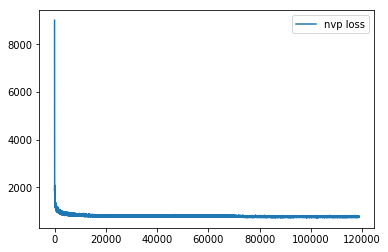

In [69]:
plt.figure()
plot(nvp_loss[::],label='nvp loss')
legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(16, 784)


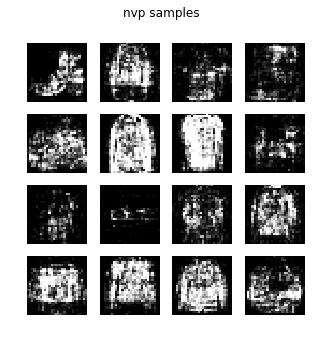

In [70]:
samples_nvp = sess.run(nvp_funcs({'x_sample':x_truth,'sample_size':16,'u_sample':np.zeros((16, data_dim))},as_dict=True)['sample'])

#print(samples_nvp.shape)
data_space  = dt.inverse(samples_nvp)
print(data_space.shape)

figure(figsize=(5,5))
suptitle('nvp samples')
for i in range(16):
    subplot(4,4,i+1)
    #test_image       = np.zeros((28*28))
    #test_image[mask] = data_space[i]
    imshow(np.reshape(data_space[i],(28,28)),cmap='gray',vmin=0,vmax=1); #colorbar()
    axis('off')
    
#plt.savefig(plot_path+'nvp_samples_%s.png'%label, bbox_inches='tight')
    
# samples_prior = sess.run(prior_sample)
# s             = sess.run(sample_mean, feed_dict={prior_samples: samples_prior})

# figure(figsize=(5,5))
# suptitle('mean likelihood of prior samples')
# for i in range(16):
#   subplot(4,4,i+1)
#   imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
#   axis('off')
# plt.savefig(plot_path+'prior_samples_%s.png'%label, bbox_inches='tight')

In [64]:
latent_space = sess.run(nvp_funcs({'x_sample':x_test_prep,'sample_size':20000,'u_sample':np.zeros((1, data_dim))},as_dict=True)['bwd_pass'])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [1]:
# plot contours of the prior
#_ = corner.corner(latent_space[:,395:-1])
_ = corner.corner(latent_space[:,0:10])

NameError: ignored

In [0]:
nvp_funcs.export(nvp_func_path,sess)